In [1]:
import pandas as pd 
import numpy as np 

# Personnal Import 
from utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts
from DL_class import MultiModelTrainer
from config import get_config,get_parameters
from plotting import plot_k_fold_split
from save_results import update_results_df
# ...

# Paths
folder_path = 'data/'

Training and Hyper-parameter tuning with Ray is not possible


In [3]:
#Init and load data: 
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

window_pred = np.arange(2*96)

# Load subway in data:
#file_name = 'preprocessed_subway_15_min.csv'
file_name = 'subway_IN_interpol_neg_15_min_16Mar2019_1Jun2020.csv'
file_name = 'subway_IN_interpol_neg_15_min_2019_2020.csv'

# Load CRITER data : 
#file_name = 'preprocessed_CRITER_6min.csv'

# Get Parameters : 

In [4]:
# Choose Model :
model_name =  'CNN' #'STGCN'

# Choose config 
config = get_config(model_name = model_name,other_params= {'seq_length':L})
#config = get_config(model_name = model_name,learn_graph_structure = True,other_params= {'seq_length':L})  # MTGNN
args = get_parameters(config)

# Modification : 
args.epochs = 100
args.optimizer = 'adamw'
args.train_prop= 0.6
args.calib_prop=None
args.valid_prop= 0.2  

# Time Embedding: 
args.type_calendar = 'tuple'
args.embedding_dim = 2

# Validation : 
args.validation = 'sliding_window'
args.K_fold = 7

## Define fixed Dataset K_fold split for each trial: 

coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00


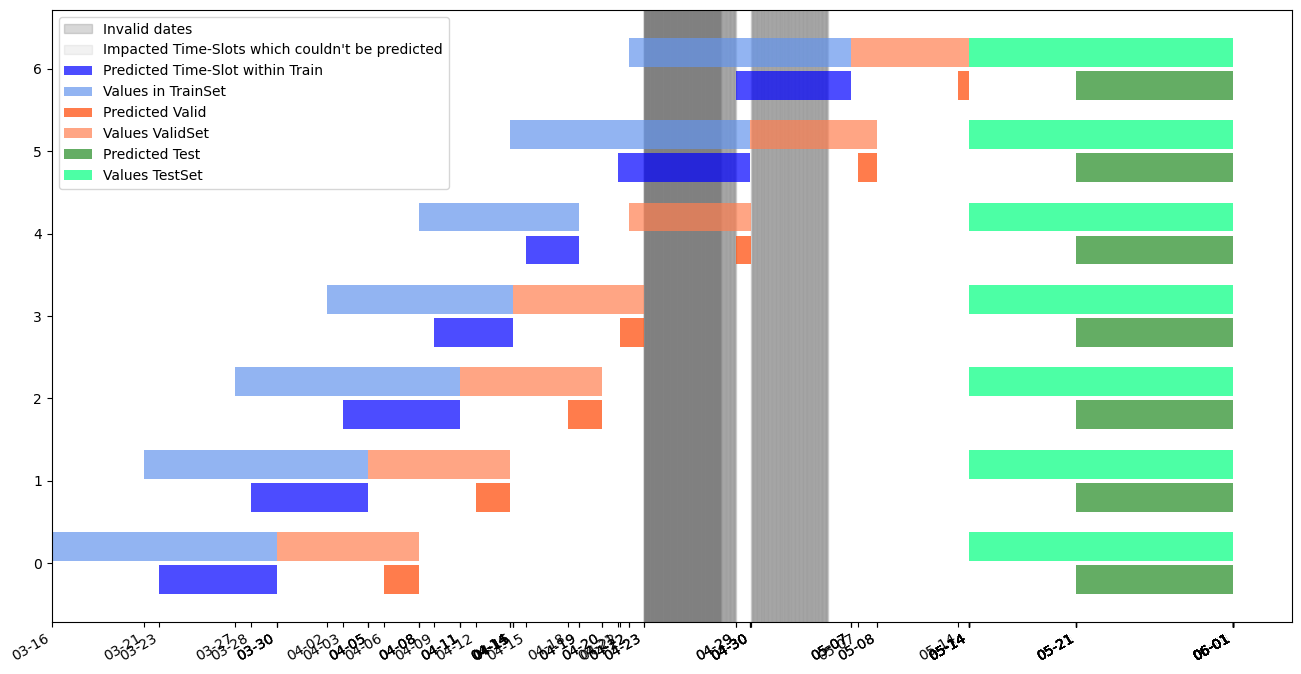

In [5]:
# Load dataset and invalid_dates 
dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,W,D,H,step_ahead,single_station = False)

# Train / Valid / Test split and Normalize for K-fold 
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args.K_fold,invalid_dates,args.train_prop, args.valid_prop,args.test_prop,args.calib_prop,args.validation,args.batch_size,type_class= args.calendar_class,type_calendar = args.type_calendar,no_common_dates_between_set = args.no_common_dates_between_set)

# Plot information about split and folds:
plot_k_fold_split(Datasets,invalid_dates)

## Loop on different config:

In [ ]:
#Init results dataframe:
results_df = pd.DataFrame()
i = 0

# Set Variable Config : 
Calendar_class = [1,2,3]
Position = ['input','output']
Specific_lr = [True,False]
Type_calendar = ['tuple','unique_long_embedding']

for calendar_class in Calendar_class:
    for position in Position:
        for specific_lr in Specific_lr:
            for type_calendar in Type_calendar:

                # Modify 'args':
                args.calendar_class = calendar_class
                args.position = position
                args.specific_lr = specific_lr
                args.type_calendar = type_calendar
                # ...


                # Load associated K_folds Models: 
                (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list)
                multimodeltrainer = MultiModelTrainer(Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False)
                (mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation()

                # Svae results 
                results_df = update_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds,i)
                i += 1
results_df.to_csv('save_results.csv')
results_df